TODO:
- Preprocess data - subtract mean (or take diff) and divide by standard dev
- Clean data - no extreme values in X or Y
- Add evaluation of validation data

In [264]:
from __future__ import division

from utils import *
from prep_data import *

import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime
from datetime import date
from datetime import timedelta
from dateutil.parser import parse

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from ggplot import *

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout
from keras import backend as K

from sklearn.utils import shuffle

%matplotlib inline
matplotlib.style.use('ggplot')

In [9]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))

In [303]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']

In [254]:
demeaning_method = 'diff'  # 'diff' or 'subtract_mean'

In [296]:
X = np.load(os.path.join(dir_data, 'X.npy'))
Y = np.load(os.path.join(dir_data, 'Y.npy'))
x_house = np.load(os.path.join(dir_data, 'x_house.npy'))
x_date = np.load(os.path.join(dir_data, 'x_date.npy'))

In [297]:
X, y, x_house, x_date = shuffle(X, Y, x_house, x_date, random_state=0)

In [298]:
# y = Y[:,0]  # fridge
y = [y_row[0] for y_row in Y]  # fridge
y = np.array(y)
y = y.reshape(y.shape[0], 1)

In [314]:
print np.array([0]).shape
print np.array([np.diff(x) for x in X]).shape

(1,)
(7560, 14400, 0)


In [309]:
np.concatenate((np.array([0]), [np.diff(x) for x in X]))

ValueError: all the input arrays must have same number of dimensions

In [299]:
# Preprocss.

# Demean.
if deameaning_method == 'diff':
    X = np.array([np.diff(x) for x in X])
elif deameaning_method == 'subtract_mean':
    X = 



In [ ]:
# Reshape as tensor.
image_data_format = K.image_data_format()  # 'channels_last'
if image_data_format == 'channels_last':
    X = X.reshape(X.shape[0], X.shape[1], 1)
elif image_data_format == 'channels_first':
    X = X.reshape(X.shape[0], 1, X.shape[1])
else:
    raise ValueError

In [319]:
model = Sequential()
model.add(Conv1D(filters=8,
                 kernel_size=6,
                 strides=2,
                 activation='relu',
                 input_shape=(N_PER_DAY, 1),
                 padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(16, 3, strides=1, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(32, 3, strides=1, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse', 'mae', 'mape'])

In [320]:
print type(X), X.shape
print type(y), y.shape

history = model.fit(X, y, epochs=3, batch_size=32)

<type 'numpy.ndarray'> (7560, 14400, 1)
<type 'numpy.ndarray'> (7560, 1)
Epoch 1/3
7560/7560 [==============================] - 65s - loss: 19.3709 - mean_squared_error: 19.3709 - mean_absolute_error: 1.1794 - mean_absolute_percentage_error: 93090134.3624             

['mean_squared_error', 'loss', 'mean_absolute_error', 'mean_absolute_percentage_error']


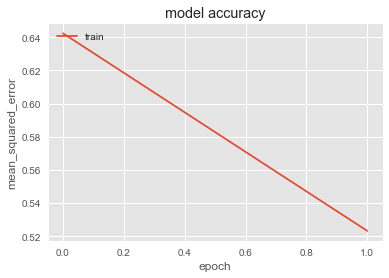

In [278]:
print(history.history.keys())
# summarize history for mse
plt.plot(history.history['mean_squared_error'][1:])
plt.title('model accuracy')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [233]:
loss_and_metrics = model.evaluate(X, y, )

7560/7560 [==============================] - 39s      

In [234]:
loss_and_metrics

[1.829324933957486, 1.829324933957486, 0.78443031806163688, 13322697.967673004]

In [321]:
y_hat = model.predict(X)

In [284]:
np.log2(y+1)

array([[ 0.9030222 ],
       [ 0.77656399],
       [ 0.93839265],
       ..., 
       [ 0.81437861],
       [ 0.89910236],
       [ 0.87662739]])

In [334]:
np.argwhere(y_hat > 5)
y_hat[1643]

array([ 23.56404305], dtype=float32)

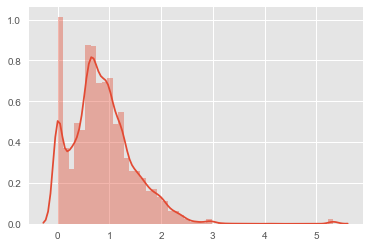

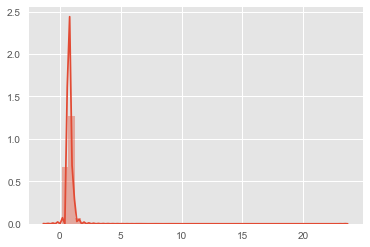

In [322]:
# sns.distplot(np.log2(y+1))
sns.distplot(y)
plt.show()
sns.distplot(y_hat)
plt.show()

(0, 5)

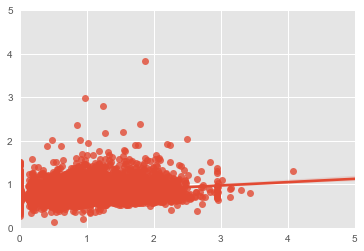

In [337]:
ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat))
ax.set_ylim(0,5)
ax.set_xlim(0,5)